In [70]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from skimage import io, color
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import random

In [71]:
# read directory

rgb_dir = os.path.join(os.getcwd(), 'dataset', '1_RGB_Frames')
depth_img_dir = os.path.join(os.getcwd(), 'dataset', '2_Depth_Frames', 'IMG')
depth_csv_dir = os.path.join(os.getcwd(), 'dataset', '2_Depth_Frames', 'CSV')

rgb_files = os.listdir(rgb_dir)
depth_img_files = os.listdir(depth_img_dir)
depth_csv_files = os.listdir(depth_csv_dir)

print('RGB files: ', len(rgb_files))
print('Depth image files: ', len(depth_img_files))
print('Depth csv files: ', len(os.listdir(depth_csv_dir)))

RGB files:  50
Depth image files:  50
Depth csv files:  50


In [72]:
timestamp_extraction = lambda x: x.split('_')[-1].rstrip('.png').split('.')[0]

In [73]:
datafiles = []
index = 0
for rgb_file in rgb_files:
    rgb_file_path = os.path.join(rgb_dir, rgb_file)
    timestamp = timestamp_extraction(rgb_file)
    # find depth image thqt matches the timestamp
    try:
        depth_img_file = [x for x in depth_img_files if timestamp in x][0]
        depth_img_file_path = os.path.join(depth_img_dir, depth_img_file)
        # find depth csv file that matches the timestamp
        depth_csv_file = [x for x in depth_csv_files if timestamp in x][0]
        depth_csv_file_path = os.path.join(depth_csv_dir, depth_csv_file)
    except:
        print('No depth file for ', rgb_file)
        continue

    datafiles.append({
        'rgb_img': rgb_file_path,
        'depth_img': depth_img_file_path,
        'depth_csv': depth_csv_file_path,
        'index': index
    })
    index += 1


No depth file for  20221117_124001_Color_1668669001690.01220703125000.png


In [74]:
def bring_to_memory(datafiles):
    newdataset = []
    for data in datafiles:
        newdata = {}
        newdata['rgb_img'] = io.imread(data['rgb_img'])
        # resize the image to 480x848
        newdata['rgb_img'] = resize(newdata['rgb_img'], (480, 848))
        # normalize the image
        newdata['rgb_img'] = newdata['rgb_img'] / 255
        newdata['depth_img'] = io.imread(data['depth_img'])
        newdata['depth_csv'] = pd.read_csv(data['depth_csv'], header=None)
        # normalize the depth csv
        # print(newdata['depth_csv'].max().max())
        newdata['depth_csv'] = newdata['depth_csv'] / newdata['depth_csv'].max().max()
        # replace all 0 values with nearest non-zero value
        newdata['depth_csv'] = newdata['depth_csv'].replace(0, 1)
        newdata['index'] = data['index']
        newdataset.append(newdata)

    return newdataset

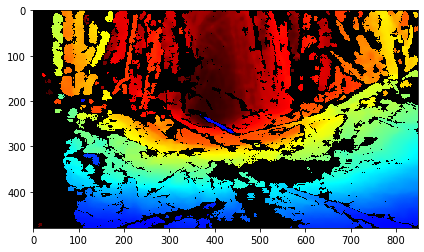

In [75]:
dataset = bring_to_memory(datafiles[0:1])
io.imshow(dataset[0]['depth_img'])
io.show()

In [76]:
def add_depth_to_rgb(rgb_img, depth_csv):
    rgb_img = np.dstack((rgb_img, depth_csv))
    return rgb_img


In [77]:
for data in dataset:
    data['processed_img'] = add_depth_to_rgb(data['rgb_img'], data['depth_csv'])

In [78]:
sample_num = random.randint(0, len(dataset))
sample = dataset[sample_num]['processed_img']

reshaped_sample = sample.reshape(-1, 1)
print(reshaped_sample.shape)
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(reshaped_sample)

(1628160, 1)


c:\Users\anish_n48e8\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=0)

c:\Users\anish_n48e8\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


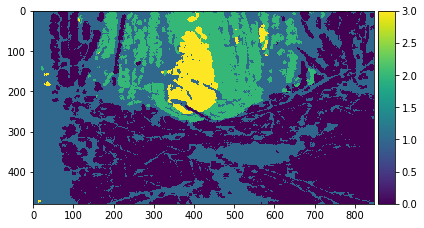

In [79]:
# impose the labels on the image
labels = kmeans.labels_
labels = labels.reshape(sample.shape[0], sample.shape[1], 4)
labels = labels[:, :, 3]
io.imshow(labels)